In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import datetime
import csv
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_csv(file_path):
    data = list()
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for raw in reader:
            data.append([float(i) for i in raw])
    return data

def prepare_data(duration):
    input_data = list()
    output_data = list()
    for i in range(29):
        file_path = f"/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/Data/filtered/filtered_{i+1}.csv"
        data = read_csv(file_path)
        num = len (data) - duration - 1
        for j in range(num):
            input_data.append([row for row in data[j:j+duration]])
            output_data.append(data[j+duration])
    return np.array(input_data), np.array(output_data)

def split_dataset(data, per):
    total_num = len(data)
    test_num = total_num * per // 100
    train_data = data[0:(total_num - test_num)]
    test_data = data[(total_num - test_num):]
    return train_data, test_data

In [ ]:
input_data, output_data = prepare_data(200//4)
input_data = np.squeeze(input_data)
train_data, test_data = split_dataset(input_data, 15)
train_label, test_label = split_dataset(output_data, 15)

In [ ]:
def lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(200//4, 9)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(9))
    model.compile(loss='mse', optimizer='adam')
    return model

def gru_model():
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(200//4, 9)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(9))
    model.compile(loss='mse', optimizer='adam')
    return model

def rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(200//4, 9)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(9))
    model.compile(loss='mse', optimizer='adam')
    return model


In [ ]:
n_timesteps = train_data.shape[1]
n_features = train_data.shape[2]
train_data = train_data.reshape(train_data.shape[0], n_timesteps * n_features)
test_data = test_data.reshape(test_data.shape[0], n_timesteps * n_features)
NewScale = MinMaxScaler(feature_range=(0,1), copy=True)
train_data = NewScale.fit_transform(train_data)
test_data = NewScale.fit_transform(test_data)
train_label = NewScale.fit_transform(train_label)
test_label = NewScale.fit_transform(test_label)
train_data = train_data.reshape(train_data.shape[0], n_timesteps, n_features)
test_data = test_data.reshape(test_data.shape[0], n_timesteps, n_features)
train_data, train_label = shuffle(train_data, train_label, random_state=1)
#test_data, test_label = shuffle(test_data, test_label, random_state=1)

In [ ]:
#LSTM Network
model_1 = lstm_model()
model_1.summary()
start = datetime.datetime.now()
trained_model_1 = model_1.fit(train_data, train_label, batch_size = 32, epochs = 60, verbose=2, validation_split = 0.15)
end = datetime.datetime.now()
train_time = end - start
print("train time for lstm is : ",train_time)
model_1.save("/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/lstm_model.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                12000     
_________________________________________________________________
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 18,009
Trainable params: 18,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
7916/7916 - 154s - loss: 8.3620e-04 - val_loss: 4.1447e-04
Epoch 2/60
7916/7916 - 154s - loss: 3.7148e-04 - val_loss: 3.3511e-04
Epoch 3/60
7916/7916 - 153s - loss: 2.8487e-04 - val_loss: 2.0122e-04
Epoch 4/60
7916/7916 - 158s - loss: 1.9908e-04 - val_loss: 1.9952e-04
Epoch 5/60
7916/7916 - 156s - loss: 1.5824e-04 - val_loss: 1.4163e-04
Epoch 6/60
7916/7916 - 156s - lo

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import load_model

model_1 = load_model('/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/lstm_model.h5')
#test_data, test_label = shuffle(test_data, test_label, random_state=1)
prediction_1 = model_1.predict(test_data)

start = datetime.datetime.now()
test_loss = model_1.evaluate(test_data, test_label)
mse = mean_squared_error(test_label[:, 8], prediction_1[:, 8])
r2 = r2_score(test_label[:, 8], prediction_1[:, 8])
end = datetime.datetime.now()
test_time = end - start
print("test time for lstm is : ",test_time)
print('Test - Loss for lstm :', test_loss)
print('Test - MSE for lstm :', mse)
print('Test - R2 Score for lstm :', r2)

1644/1644 [==============================] - 9s 6ms/step - loss: 2.4033e-04
test time for lstm is :  0:00:09.463537
Test - Loss for lstm : 0.00024032712099142373
Test - MSE for lstm : 0.0006643072606880099
Test - R2 Score for lstm : 0.9916720102299793


(52585, 9)


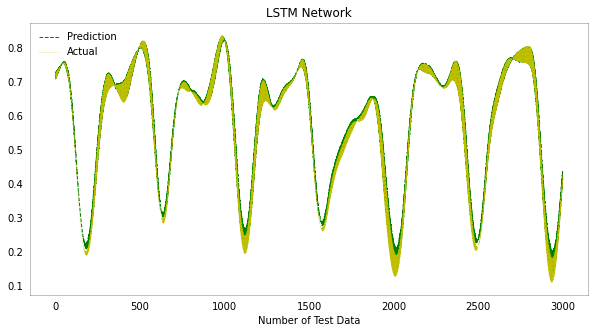

In [ ]:
plt.figure(figsize = [10,5])
print(prediction_1.shape)
plt.plot(prediction_1[10000:13000, 8], label='Prediction', linewidth=1, c='g', linestyle='--')
plt.plot(test_label[10000:13000, 8], label='Actual', linewidth=0.5, c='y', linestyle=':')
plt.legend(frameon=False)
plt.xlabel('Number of Test Data')
plt.title("LSTM Network")
plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True)   
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
plt.savefig('/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/lstm_prediction.png', dpi = 300)

In [ ]:
# for load a model use this:
#from keras.models import load_model
#model = load_model('/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/gru_model.h5')
#more information:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/